# Modifying the `fit_MLE()` function
### Method
1. Use `fit_MLE()` to fit a $A$ and $B$ matrix
2. Get the initial state distribution $a$ from the eigenvectors of $A$
3. Fit the HMM to get a set of hidden states and observations
4. Generate 1000 samples from the HMM model and plot the FDC
5. Repeat with fit_MCMC()

In [1]:
# make sure all required packages are installed
import Pkg
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `c:\Users\lbl59\OneDrive - Cornell University\Classes\Y3-SP23\BEE6940\Project\HMM Training`


In [2]:
# load all packages
using Random
using CSVFiles # load CSV data
using DataFrames # data storage and presentation
using Plots # plotting library
using StatsPlots # statistical plotting
using Distributions # statistical distribution interface
using Turing # probabilistic programming and MCMC
using Optim # optimization library
using StatsBase
using LaTeXStrings
using HMMBase
using DelimitedFiles
using CSV;

In [3]:
# load data
# source: https://github.com/IMMM-SFA/msd_uncertainty_ebook/tree/main/notebooks/data
Q = CSV.File("annualQ.csv", header=[:Inflow]) |> DataFrame
Q = Q[2:end,:]
Q[!,:Inflow] = parse.(Float64, Q[!, :Inflow])
Q[!, :Year] = 1909:2013;
Q[!, :logQ] = log.(Q[!, :Inflow]);

In [4]:
# Assume first-order HMM where only the immediate prior step influences the next step
n_states = 2
logQ = Q[!,:logQ];
n_years = size(logQ)[1];

In [5]:
# Set the random seed
Random.seed!(1)

TaskLocalRNG()

### Define useful functions

In [6]:
function stat_matrix(A)
    evecs = eigen(transpose(A)).vectors # the stationary distribution
    evals = eigen(transpose(A)).values 
    a = zeros(2)
    for (i, val) in enumerate(evals)
       
        if val == 1.0
            a = evecs[:, i]
            #println(dist)
            a /= sum(a)
            #println(dist)
            #push!(a, dist)
        end
    end
    #a = Float64.(a)
    return a
end

stat_matrix (generic function with 1 method)

In [7]:
# function to plot the distribution of the wet and dry states 
using LinearAlgebra
function plot_dist(Q, μ, σ, A)
    evals, evecs = eigen(A).values, eigen(A).vectors
    one_eval = argmin(abs.(evals.-1))
    π = evecs[:, one_eval] / sum(evecs[:, one_eval])

    x_0 = LinRange(μ[1] - 4*σ[1], μ[1] + 4*σ[1], 10000)
    norm0 = Normal(μ[1], σ[1])
    fx_0 = π[1].*pdf.(norm0, x_0)
 
    x_1 = LinRange(μ[2] - 4*σ[2], μ[2] + 4*σ[2], 10000)
    norm1 = Normal(μ[2], σ[2])
    fx_1 = π[2].*pdf.(norm1, x_1)
 
    x = LinRange(μ[1] - 4*σ[1], μ[2] + 4*σ[2], 10000)
    fx = π[1].*pdf.(norm0, x) .+ π[2].*pdf.(norm1, x)
    
    #fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    b = range(μ[1] - 4*σ[1], μ[2] + 4*σ[2], length=100)
    
    histogram(log.(Q), c=:lightgrey, normalize=:pdf, label="Log-Inflow")
    plot!(x_0, fx_0, c=:red, linewidth=3, label="Dry State Distr", xlabel="x", ylabel="P(x)")
    plot!(x_1, fx_1, c=:blue, linewidth=2, label="Wet State Distr")
    plot!(x, fx, c=:black, linewidth=2, label="Combined State Distr")
end

plot_dist (generic function with 1 method)

In [8]:
quantile(logQ, 0.25)

15.289526606243784

### Some notes
- MCMC very sensitive to prior distribution parameterization
- For $\mu_2$ (dry state), the *larger* the std dev of the normal distribution, the nicer the plot looks (but needs to remain between 0.3-1.0)
- information on the prior is a MUST, NCNC method not valuable otherwise

In [9]:
@model function HMM_mcmc(logQ, n_states, n_years)
    # Source: https://chat.openai.com/c/d81ef577-9a2f-40b2-be9d-c19bf89f9980
    # Prompt example: Please suggest how you would parameterize Hidden Markov Model with the Markov Chain Monte Carlo method 
    # Uses the Turing.jl package in Julia. The input to this model will be an inflow timeseries with two hidden states.
    mean_logQ = mean(logQ)

    μ₁ ~ Normal(15.7, 0.25)   # wet state   
    μ₂ ~ Normal(15.2, 0.25)   # dry state
    σ₁ ~ truncated(Normal(0.24, 0.1), 0, Inf)
    σ₂ ~ truncated(Normal(0.24, 0.1), 0, Inf)
    a11 ~ Dirichlet(ones(n_states))
    A ~ filldist(Dirichlet(ones(n_states)), n_states)
    s = tzeros(Int, n_years)   # Define the vector of hidden states

    # Define intial state probability distribution
    a = [a11[1], 1-a11[1]]   # [wet state, dry state]

    # Define the observation distributions 
    B = [Normal(μ₁, σ₁), Normal(μ₂, σ₂)]

    # Sample the initial hidden state and observation variables
    s[1] ~ Categorical(a)

    # Loop over time steps and sample the hidden+observed variables 
    for t in 2:n_years
        s[t] ~ Categorical(A[:,s[t-1]])
    end
    for t in 1:n_years
        logQ[t] ~ B[s[t]]

        # if the logQ is greater than the input mean, force the state to be a wet state
        if logQ[t] > mean_logQ
            s[t] ~ Categorical(A[:,1])
        # if the logQ is smaller than the input mean, force the state to be a dry state
        elseif logQ[t] < mean_logQ
            s[t] ~ Categorical(A[:,2])
        end

    end
end

HMM_mcmc (generic function with 2 methods)

### Notes:
- Iter 2500, chain 1 insufficient for convergence
- Iter 5000, chain 1 insufficient for convergence
- Iter 6000, chain 1 insufficient for convergence
- Iter 7000, chain 4 insufficient for convergence

In [10]:
# run for 3000 iterations; usually enough
# run using >3 chains to double check convergence if desired
hmm_model = HMM_mcmc(logQ, n_states, n_years)
g = Gibbs(HMC(0.05, 10, :μ₁, :μ₂, :σ₁, :σ₂, :a11, :A), PG(10, :s))
chains = sample(hmm_model, g, MCMCThreads(), 3000, 1, drop_warmup=true)
#chains = sample(hmm_model, HMC(0.1, 5), 1000)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\lbl59\.julia\packages\AbstractMCMC\F9Hbk\src\sample.jl:296
Sampling (1 threads)   0%|█                             |  ETA: N/A

Sampling (1 threads) 100%|██████████████████████████████| Time: 0:05:26


Sampling (1 threads) 100%|██████████████████████████████| Time: 0:05:27

Chains MCMC chain (3000×116×1 Array{Float64, 3}):

Iterations        = 1:1:3000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 308.77 seconds
Compute duration  = 308.77 seconds
parameters        = μ₁, μ₂, σ₁, σ₂, a11[1], a11[2], A[1,1], A[2,1], A[1,2], A[2,2], s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[8], s[9], s[10], s[11], s[12], s[13], s[14], s[15], s[16], s[17], s[18], s[19], s[20], s[21], s[22], s[23], s[24], s[25], s[26], s[27], s[28], s[29], s[30], s[31], s[32], s[33], s[34], s[35], s[36], s[37], s[38], s[39], s[40], s[41], s[42], s[43], s[44], s[45], s[46], s[47], s[48], s[49], s[50], s[51], s[52], s[53], s[54], s[55], s[56], s[57], s[58], s[59], s[60], s[61], s[62], s[63], s[64], s[65], s[66], s[67], s[68], s[69], s[70], s[71], s[72], s[73], s[74], s[75], s[76], s[77], s[78], s[79], s[80], s[81], s[82], s[83], s[84], s[85], s[86], s[87], s[88], s[89], s[90], s[91], s[92], s[93], s[94], s[95], s[96], s[97], s[98], s[99], s[100], s[101], s[102], s[103], s[1

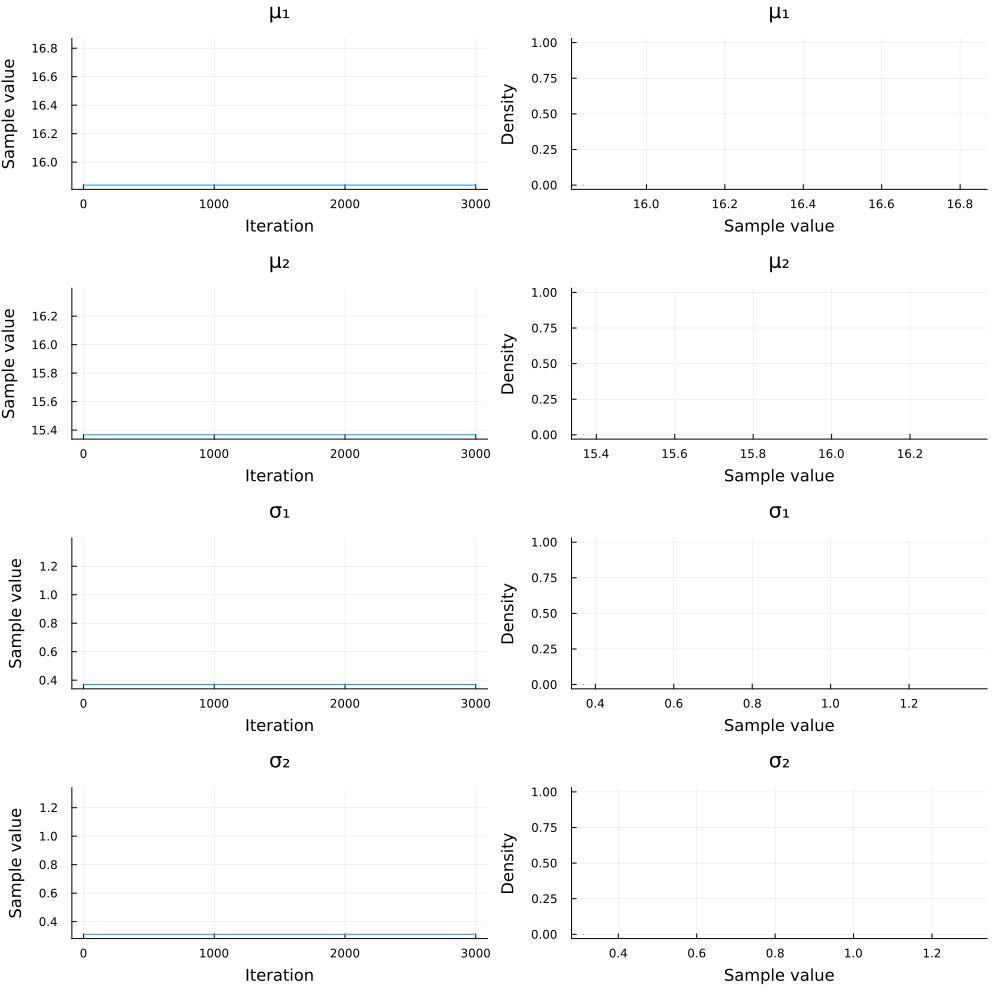

In [13]:
# Plot the chain plots to check for convergence
plot(chains, [:μ₁, :μ₂, :σ₁, :σ₂])
#savefig("Figures/Iter1000_Chain1.png")

In [81]:
# Plot the corner plots for the chain to check for parameter dependencies 
corner(chains, [:μ₁, :μ₂, :σ₁, :σ₂])
#savefig("Figures/Iter5000_Chain1_corner.png")

"c:\\Users\\lbl59\\OneDrive - Cornell University\\Classes\\Y3-SP23\\BEE6940\\Project\\HMM Training\\Figures\\Iter5000_Chain1_corner.png"

In [22]:
function predict_inflow(chain, logQ)
    μ₁ = Array(group(chain, :μ₁))
    μ₂ = Array(group(chain, :μ₂))
    σ₁ = Array(group(chain, :σ₁))
    σ₂ = Array(group(chain, :σ₂))
    a11 = Array(group(chain, "a11[1]"))
    a22 = Array(group(chain, "a11[2]"))
    A11 = Array(group(chain, "A[1,1]"))
    A12 = Array(group(chain, "A[1,2]"))
    A21 = Array(group(chain, "A[2,1]"))
    A22 = Array(group(chain, "A[2,2]"))

    n_samples = 1000
    
    μ1_sample = sample(μ₁, n_samples, replace=true);
    μ2_sample = sample(μ₂, n_samples, replace=true);
    σ1_sample = sample(σ₁, n_samples, replace=true);
    σ2_sample = sample(σ₂, n_samples, replace=true);
    a11_sample = sample(a11, n_samples, replace=true);
    a22_sample = sample(a22, n_samples, replace=true);
    A11_sample = sample(A11, n_samples, replace=true);
    A12_sample = sample(A12, n_samples, replace=true);
    A21_sample = sample(A21, n_samples, replace=true);
    A22_sample = sample(A22, n_samples, replace=true);
    
    Q_predict = zeros(length(logQ), n_samples)    
    #residuals_ar = zeros(length(temp_data), n_samples)
    
    s_matrix = zeros(length(logQ), n_samples)
    logQ_matrix = zeros(length(logQ), n_samples)
    meanQ = mean(logQ)
    
    for n = 1:n_samples 
        s_sample = tzeros(Int, n_years)
        Q_sample = zeros(n_years)

        μ1 = μ1_sample[n]
        μ2 = μ2_sample[n]
        σ1 = σ1_sample[n]
        σ2 = σ2_sample[n]
        a11 = a11_sample[n]
        a22 = a22_sample[n]
        A11 = A11_sample[n]
        A21 = 1 - A11_sample[n]
        A12 = 1 - A22_sample[n]
        A22 = A22_sample[n]
        #println(A)
        A = [A11 A12; A21 A22]
        A = transpose(A)
        #println(A)
        #a =  [1-a22, a22]
        a = [a11, 1-a11]
        print(a)
        B = [Normal(μ1, σ1), Normal(μ2, σ2)]

        # Sample the initial hidden state and observation variables
        s_sample[1] = rand(Categorical(a))

        # Loop over time steps and sample the hidden+observed variables 
        for t in 2:n_years
            s_sample[t] = rand(Categorical(A[s_sample[t-1], :]))
        end
        for t in 1:n_years
            Q_sample[t] = rand(B[s_sample[t]])
            if Q_sample[t] < meanQ
                s_sample[t] = 1
            elseif Q_sample[t] > meanQ
                s_sample[t] = 2
            end
        end

        s_matrix[:, n] = s_sample
        Q_predict[:, n] = Q_sample
        
    end

    return s_matrix, Q_predict

end

predict_inflow (generic function with 1 method)

In [23]:
s_matrix, logQ_predict = predict_inflow(chains, logQ)

[0.47272522929989397, 0.527274770700106][0.011037809517367244, 0.9889621904826328][0.8041723232581878, 0.19582767674181223][0.8755694942620617, 0.12443050573793835][0.5027021346196671, 0.49729786538033294][0.6234282638626317, 0.3765717361373683][0.9152593450012384, 0.0847406549987616][0.8161263421998265, 0.1838736578001735][0.18882360540751192, 0.8111763945924881][0.8632965194821068, 0.13670348051789316][0.05601003963594739, 0.9439899603640526][0.9874419473066297, 0.012558052693370292][0.8438718000960069, 0.15612819990399307][0.5019606575821377, 0.4980393424178623][0.02072555728582339, 0.9792744427141766][0.002383604971255973, 0.997616395028744][0.13539838258622605, 0.864601617413774][0.9108296339583498, 0.08917036604165018][0.7555453597863027, 0.24445464021369734][0.13982032387783896, 0.8601796761221611][0.8484638041358581, 0.1515361958641419][0.842342940117211, 0.157657059882789][0.44099783903002593, 0.559002160969974][0.8699581268274648, 0.13004187317253524][0.10707119539633564, 0.8

][0.513635860543957, 0.48636413945604295][0.26410693674763186, 0.7358930632523681][0.2896996913235484, 0.7103003086764517][0.7960173430723062, 0.2039826569276938][0.5507418143145318, 0.44925818568546816][0.43553161824510095, 0.564468381754899][0.05601003963594739, 0.9439899603640526][0.04546658191077894, 0.9545334180892211][0.13938108128577575, 0.8606189187142242][0.8810352416425725, 0.11896475835742748][0.5508652694434074, 0.4491347305565926][0.31555371730770343, 0.6844462826922966][0.15015427633826678, 0.8498457236617332][0.4991527110654647, 0.5008472889345352][0.7753522814355338, 0.2246477185644662][0.7644115153489653, 0.23558848465103466][0.17650051168187528, 0.8234994883181247][0.2399874007466746, 0.7600125992533254][0.024958345810302065, 0.9750416541896979][0.15247996822103613, 0.8475200317789638][0.4737274042979751, 0.5262725957020249][0.8518751435093381, 0.14812485649066187][0.19433607999836347, 0.8056639200016366][0.7144098195416483, 0.2855901804583517][0.9448154518296701, 0.0

][0.5630909237237407, 0.4369090762762593][0.8817427895700968, 0.11825721042990323][0.581604698798506, 0.41839530120149404][0.6120259045270148, 0.3879740954729852][0.819074120579723, 0.18092587942027705][0.7452055027189423, 0.25479449728105774][0.7370088480675094, 0.26299115193249056][0.6463225620252626, 0.3536774379747374][0.0331176588408819, 0.9668823411591181][0.9918386469748836, 0.008161353025116447][0.9596857465182123, 0.04031425348178774][0.5604223622977847, 0.43957763770221525][0.3794361637064024, 0.6205638362935977][0.052830405001016136, 0.9471695949989839][0.7381017760206428, 0.26189822397935725][0.4338358760963975, 0.5661641239036025][0.025985333265172175, 0.9740146667348278][0.7978023295884088, 0.2021976704115912][0.6465846477551681, 0.3534153522448319][0.7385307384643268, 0.2614692615356732][0.15585370749452346, 0.8441462925054766][0.8195457779841561, 0.18045422201584393][0.7108247286330501, 0.28917527136694987][0.041698691200843345, 0.9583013087991566][0.7664465018799739, 0

, 0.6471413366049372][0.8102109123724381, 0.18978908762756186][0.7529824510920851, 0.24701754890791494][0.46628815620674174, 0.5337118437932582][0.021753837903263736, 0.9782461620967363][0.6895376487180803, 0.3104623512819197][0.947189207424094, 0.05281079257590604][0.8068576107351527, 0.19314238926484728][0.15683260471675772, 0.8431673952832422][0.39369370468971565, 0.6063062953102843][0.7218324636328796, 0.27816753636712044][0.3520294890083919, 0.6479705109916081][0.5353096207627629, 0.4646903792372371][0.4566889127221594, 0.5433110872778406][0.589578462684584, 0.410421537315416][0.777675620400979, 0.22232437959902096][0.6620891725352426, 0.3379108274647574][0.5315346605741116, 0.4684653394258884][0.060789817009304, 0.939210182990696][0.9272010244154769, 0.07279897558452308][0.9341527787006246, 0.06584722129937537][0.7000875860582892, 0.29991241394171075][0.018814264052924478, 0.9811857359470755][0.2980665730857633, 0.7019334269142368][0.1776466515431965, 0.8223533484568035][0.021753

, 0.2844493496282148][0.7705785206991762, 0.2294214793008238][0.6831060840977844, 0.3168939159022156][0.22371886839835772, 0.7762811316016422][0.09667484564224764, 0.9033251543577524][0.13089083157799114, 0.8691091684220089][0.3609737792929439, 0.6390262207070561][0.3067667213417158, 0.6932332786582842][0.8370433389002514, 0.1629566610997486][0.9360028622920512, 0.06399713770794879][0.7575182300223309, 0.24248176997766913][0.7157108656094373, 0.2842891343905627][0.039278319665412946, 0.960721680334587][0.9805103813479437, 0.01948961865205634][0.8946643405453647, 0.1053356594546353][0.9232347449190722, 0.0767652550809278][0.9761201412758141, 0.023879858724185854][0.446572228846875, 0.553427771153125][0.4933521754726155, 0.5066478245273844][0.37336292773219176, 0.6266370722678083][0.5618679661127504, 0.43813203388724964][0.8566970638533413, 0.14330293614665868][0.514418535022022, 0.48558146497797805][0.7935038648534101, 0.20649613514658993][0.521437223387792, 0.47856277661220803][0.55820

][0.674110317436366, 0.32588968256363404][0.891204100486681, 0.10879589951331903][0.013675909250338342, 0.9863240907496617][0.9857899737369453, 0.014210026263054676][0.7052944260588259, 0.29470557394117414][0.6022813678434014, 0.39771863215659864][0.5909000490212797, 0.4090999509787203][0.6890174603733444, 0.31098253962665556][0.7651324986228997, 0.23486750137710033][0.45140265159923865, 0.5485973484007614][0.18612482586458415, 0.8138751741354159][0.8649046402473789, 0.1350953597526211][0.5507418143145318, 0.44925818568546816][0.4206261055197261, 0.5793738944802739][0.49906087805604915, 0.5009391219439508][0.8649046402473789, 0.1350953597526211][0.8610255935605933, 0.13897440643940673][0.07309697515582052, 0.9269030248441795][0.5935525883466001, 0.4064474116533999][0.803959235622707, 0.196040764377293][0.27307274463009334, 0.7269272553699067][0.4567304430695345, 0.5432695569304655][0.022454006744350132, 0.9775459932556498][0.3799303845929412, 0.6200696154070588][0.95717811608945, 0.042

([2.0 1.0 … 2.0 1.0; 1.0 2.0 … 2.0 2.0; … ; 2.0 2.0 … 1.0 1.0; 2.0 2.0 … 1.0 1.0], [15.673435178728985 15.354265893219742 … 16.03717561102583 15.45224930834129; 14.71977108204696 15.910580846718503 … 15.654715821883425 15.97613171678467; … ; 15.731145495877625 15.887024074516592 … 15.40351731018144 15.250201517034057; 15.67872498567726 15.838505590403717 … 15.170056318200235 15.382671323837616])

In [24]:
posterior_param_means = mean(chains)[:, :mean] 

115-element Vector{Float64}:
 15.606821066960352
 15.393913270312797
  0.27864086451624037
  0.29120316310899225
  0.5778924004118179
  0.4221075995881821
  0.519678783358277
  0.4803212166417229
  0.4661603730249323
  0.5338396269750677
  ⋮
  1.4806666666666666
  1.4906666666666666
  1.485
  1.4733333333333334
  1.4773333333333334
  1.5233333333333334
  1.4593333333333334
  1.6116666666666666
  1.6743333333333332

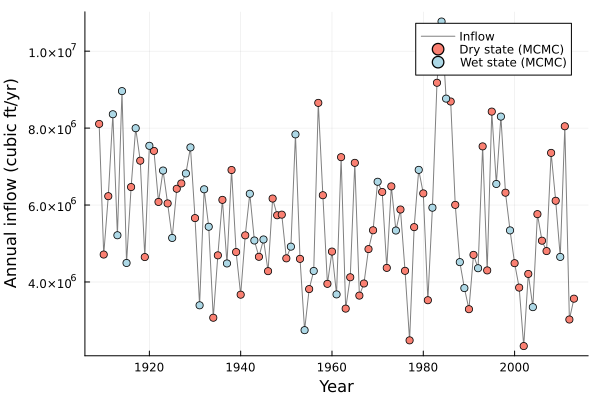

In [34]:
# dry and wet masks
q = Q[!,:Inflow]
y = Q[!,:Year]

idx = 7
Q_wet_mcmc = q[s_matrix[:,idx] .== 1]
Q_dry_mcmc = q[s_matrix[:,idx] .== 2]

y_wet_mcmc = y[s_matrix[:,idx] .== 1]
y_dry_mcmc = y[s_matrix[:,idx] .== 2];

plot(y, Q.Inflow, c=:grey, label="Inflow", xlabel="Year", ylabel="Annual inflow (cubic ft/yr)")
scatter!(y_dry_mcmc, Q_dry_mcmc, c=:salmon, label="Dry state (MCMC)", xlabel="Year", ylabel="Annual inflow (cubic ft/yr)")
scatter!(y_wet_mcmc, Q_wet_mcmc, c=:lightblue, label="Wet state (MCMC)", xlabel="Year", ylabel="Annual inflow (cubic ft/yr)")
#savefig("Figures/hmm_mcmc_wetdrystates.png")

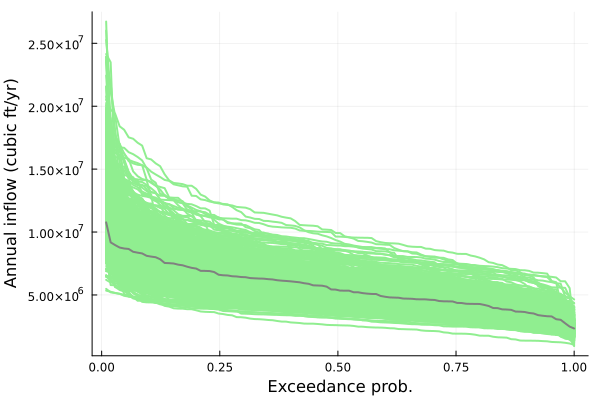

In [32]:
# plot the FDC of the sampled inflow around the historical 
sampled_obs_mcmc = zeros(1000, n_years)
Q_predict_mcmc = transpose(logQ_predict)
for i in 1:1000
    sampled_obs_mcmc[i,:] = exp.(Q_predict_mcmc[i, :])
    sampled_obs_mcmc[i,:] = sort!(sampled_obs_mcmc[i, :], rev=true)
end

hist_obs = copy(Q[!,:Inflow])
hist_obs = sort!(hist_obs, rev=true)
probs = (1:n_years)/n_years

plot(probs, hist_obs, c=:grey, linewidth=2, label="Historical inflow",
    xlabel="Exceedance prob.", ylabel="Annual inflow (cubic ft/yr)")
for i in 1:1000
    if i == 1
        plot!(probs, sampled_obs_mcmc[i,:], c=:lightgreen, linewidth=2,
            label="Sampled inflow (MCMC)", xlabel="Exceedance prob.", ylabel="Annual inflow (cubic ft/yr)")
    end

    plot!(probs, sampled_obs_mcmc[i,:], c=:lightgreen, linewidth=2, legend=false,
        xlabel="Exceedance prob.", ylabel="Annual inflow (cubic ft/yr)")
end

plot!(probs, hist_obs, c=:grey, linewidth=2, legend=false,
    xlabel="Exceedance prob.", ylabel="Annual inflow (cubic ft/yr)")

#savefig("Figures/hmm_mcmc_FDC.png")

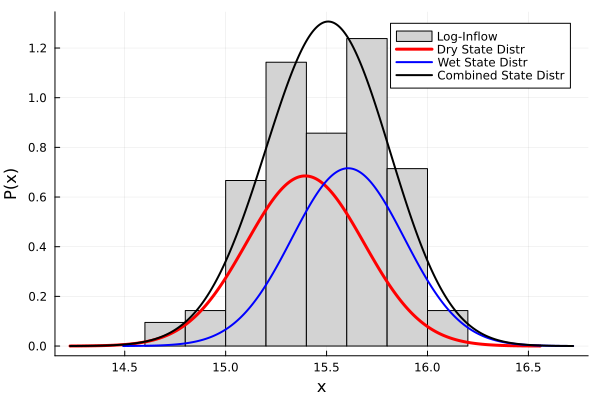

In [33]:
μ₁_mean = mean(chains, :μ₁)
μ₂_mean = mean(chains, :μ₂)
σ₁_mean = mean(chains, :σ₁)
σ₂_mean = mean(chains, :σ₂)
a11_mean = mean(chains, "a11[2]")
A11_mean = mean(chains, "A[1,1]")
A12_mean = mean(chains, "A[1,2]")
A21_mean = mean(chains, "A[2,1]")
A22_mean = mean(chains, "A[2,2]")
#a22_mean = mean(chains, :a22)

# obtained from model above
μ = [μ₂_mean, μ₁_mean]
σ = [σ₂_mean, σ₁_mean]
A_mcmc = [A11_mean 1-A11_mean; 1-A22_mean A22_mean]
#A_mcmc = [A11_mean A21_mean; A12_mean A22_mean]
plot_dist(Q[!,:Inflow], μ, σ, A_mcmc)
#savefig("Figures/hmm_mcmc_dist.png")